In [1]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import jax
import itertools
import sys
import math
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

from scipy.special import comb

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [3]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json')
H_2005_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_smc_samples.json')
O_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss= load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json')
vK_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_smc_samples.json')
R_2015_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json')
K_2017_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
vK_2009_log_magr = np.mean([chain[-1] for chain in VK_2009_ss['log_marginal_likelihood'][0]]) 
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood'][0]])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood']])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])
H_2005_log_magr = np.mean([chain[-1] for chain in H_2005_ss['log_marginal_likelihood'][0]])

# Levchenko 2000 has 800 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
L_2000_posts = [L_2000_post for _ in range(10)]
L_2000_post = np.vstack(L_2000_posts)[rng.permutation(np.arange(4000))]

# Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
B_2007_posts = [B_2007_post for _ in range(10)]
B_2007_post = np.vstack(B_2007_posts)[rng.permutation(np.arange(4000))]

# Orton 2009 only has 1000 posterior predictive samples, so we duplicate and randomly permute them to get 4000
O_2009_posts = [O_2009_post for _ in range(10)]
O_2009_post = np.vstack(O_2009_posts)[rng.permutation(np.arange(4000))]

# vonKreigsheim 2009 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
vK_2009_posts = [vK_2009_post for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)[rng.permutation(np.arange(4000))]

# Hornberg 2005 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
H_2005_posts = [H_2005_post for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)[rng.permutation(np.arange(4000))]

# downsample Shin 2014
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
S_2014_post_downsample = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

colors = get_color_pallette()

We want to construct MMI estimators with decreasing numbers of models from 9 to 2

In [4]:
# function to compute model probs
def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

def model_probs(log_marginal_likes):
    """Computes the model probabilities from a list of log marginal likelihoods."""

    n_models = len(log_marginal_likes)
    prior_prob = 1/n_models
    model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)
    

    return model_probs

Compute MMI and associated uncertainty for all models

In [5]:
# set up model names and display names and other data for all models
model_names_all = ['kholodenko_2000', 'levchenko_2000','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names_all = ["K' 2000", "L' 2000", "H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
log_marginal_likes_all = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
dict_compare_all = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata, 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}
posterior_samples_all = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post, K_2017_post]


compare_data_loo_pbma_all = az.compare(dict_compare_all, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_all = az.compare(dict_compare_all, ic='loo', method='stacking')
model_probs_all = model_probs(log_marginal_likes_all)
stack_weight_all = [compare_data_loo_stack_all.loc[model]['weight'] for model in model_names_all]
pBMA_weight_all = [compare_data_loo_pbma_all.loc[model]['weight'] for model in model_names_all]

loo_pbma_combined_all = np.zeros_like(posterior_samples_all[0])
loo_stack_combined_all = np.zeros_like(posterior_samples_all[0])
loo_bma_combined_all = np.zeros_like(posterior_samples_all[0])
for i, name in enumerate(model_names_all):
    loo_pbma_combined_all += compare_data_loo_pbma_all.loc[name]['weight']*posterior_samples_all[i]
    loo_stack_combined_all += compare_data_loo_stack_all.loc[name]['weight']*posterior_samples_all[i]
    loo_bma_combined_all += model_probs_all[i]*posterior_samples_all[i]


# compute errors of all models
RMSE_models_all = []
errors_models_all = []
for i, name in enumerate(model_names_all):
    RMSE_models_all.append(np.sqrt(np.mean((np.mean(posterior_samples_all[i] - data.T, axis=0))**2)))
    errors_models_all.append(np.linalg.norm(np.mean(posterior_samples_all[i] - data.T, axis=0))/np.linalg.norm(data.T))

# MMI w/ all
RMSE_all = []

RMSE_all.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_stack_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_bma_combined_all - data.T, axis=0))**2)))

error_all = []

error_all.append(np.linalg.norm(np.mean(loo_pbma_combined_all - data.T, axis=0))/np.linalg.norm(data.T))
error_all.append(np.linalg.norm(np.mean(loo_stack_combined_all - data.T, axis=0))/np.linalg.norm(data.T))
error_all.append(np.linalg.norm(np.mean(loo_bma_combined_all - data.T, axis=0))/np.linalg.norm(data.T))

# Just models
uncert_95_models_all = []
for i, name in enumerate(model_names_all):
    uncert_95_models_all.append(np.mean(np.diff(np.quantile(posterior_samples_all[i], [0.025, 0.975], axis=0), axis=0)))

# MMI w/ all
uncert_95_all = []

uncert_95_all.append(np.mean(np.diff(np.quantile(loo_pbma_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_stack_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_bma_combined_all, [0.025, 0.975], axis=0), axis=0)))


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to 

Now run for all combinatoric subsets of models

In [6]:
n_models = 9
n_combos = sum([comb(n_models, i) for i in range(1, n_models)])
count = 0
errors_pBMA = {}
RMSE_pBMA = {}
uncertainties_pBMA = {}
errors_BMA = {}
RMSE_BMA = {}
uncertainties_BMA = {}
errors_stack = {}
RMSE_stack = {}
uncertainties_stack = {}

model_sets = {}

for subset_length in range(1, n_models):
    print('Running {} models'.format(subset_length))
    RMSE_pBMA[subset_length] = []
    errors_pBMA[subset_length] = []
    uncertainties_pBMA[subset_length] = []
    errors_BMA[subset_length] = []
    RMSE_BMA[subset_length] = []
    uncertainties_BMA[subset_length] = []
    errors_stack[subset_length] = []
    RMSE_stack[subset_length] = []
    uncertainties_stack[subset_length] = []

    # loop over all possible combinations of models at this subset length
    for subset_idxs in itertools.combinations(range(n_models), subset_length):
        # get the model names for this subset
        model_subset = [model_names_all[idx] for idx in subset_idxs]

        # get the log marginal likelihoods and idata for the subset of models
        log_marg_subset = log_marginal_likes_all[list(subset_idxs)]
        posterior_samples_subset = [posterior_samples_all[idx] for idx in subset_idxs]
        dict_compare_subset = {model: dict_compare_all[model] for model in model_subset}

        if subset_length == 1:
            # if there's only one model, the model probabilities are 1
            model_probs_subset = np.array([1])
            pBMA_weight = np.array([1])
            stack_weight = np.array([1])
        else:
            # compute the model probabilities
            model_probs_subset = model_probs(log_marg_subset)

            # compute pBMA weights
            compare_data_loo_pbma_subset = az.compare(dict_compare_subset, ic='loo', method='BB-pseudo-BMA')
            pBMA_weight = [compare_data_loo_pbma_subset.loc[model]['weight'] for model in model_subset]

            # compute stacking weights
            compare_data_loo_stack_subset = az.compare(dict_compare_subset, ic='loo', method='stacking')
            stack_weight= [compare_data_loo_stack_subset.loc[model]['weight'] for model in model_subset]

        # compute the combined posterior samples
        loo_pbma_combined_subset = np.zeros_like(posterior_samples_subset[0])
        loo_stack_combined_subset = np.zeros_like(posterior_samples_subset[0])
        loo_bma_combined_subset = np.zeros_like(posterior_samples_subset[0])
        for j, name in enumerate(model_subset):
            loo_pbma_combined_subset += pBMA_weight[j]*posterior_samples_subset[j]
            loo_stack_combined_subset += stack_weight[j]*posterior_samples_subset[j]
            loo_bma_combined_subset += model_probs_subset[j]*posterior_samples_subset[j]

        # compute the errors and uncertainties
        RMSE_pBMA[subset_length].append(np.sqrt(np.mean((np.mean(loo_pbma_combined_subset - data.T, axis=0))**2)))
        RMSE_stack[subset_length].append(np.sqrt(np.mean((np.mean(loo_stack_combined_subset - data.T, axis=0))**2)))
        RMSE_BMA[subset_length].append(np.sqrt(np.mean((np.mean(loo_bma_combined_subset - data.T, axis=0))**2)))

        errors_pBMA[subset_length].append(np.linalg.norm(np.mean(loo_pbma_combined_subset - data.T, axis=0))/np.linalg.norm(data.T))
        errors_BMA[subset_length].append(np.linalg.norm(np.mean(loo_bma_combined_subset - data.T, axis=0))/np.linalg.norm(data.T))
        errors_stack[subset_length].append(np.linalg.norm(np.mean(loo_stack_combined_subset - data.T, axis=0))/np.linalg.norm(data.T))

        uncertainties_pBMA[subset_length].append(np.mean(np.diff(np.quantile(loo_pbma_combined_subset, [0.025, 0.975], axis=0), axis=0)))
        uncertainties_stack[subset_length].append(np.mean(np.diff(np.quantile(loo_stack_combined_subset, [0.025, 0.975], axis=0), axis=0)))
        uncertainties_BMA[subset_length].append(np.mean(np.diff(np.quantile(loo_bma_combined_subset, [0.025, 0.975], axis=0), axis=0)))

Running 1 models
Running 2 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to 

Running 3 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to 

Running 4 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3

Running 5 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: U

Running 6 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3

Running 7 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: U

Running 8 models


/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to 

Make box plots of dists of RMSE and uncertainty for each subset size

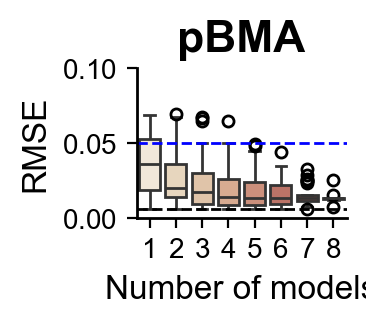

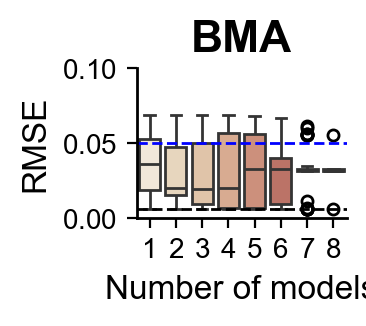

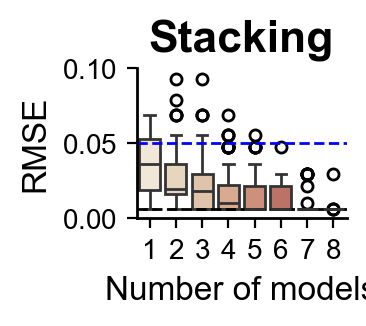

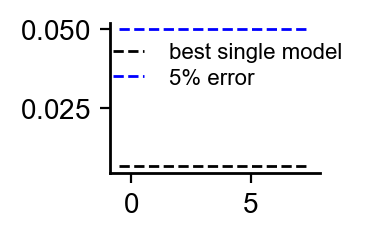

In [11]:
colors = sns.color_palette("OrRd", 8, desat=0.65)

# pBMA RMSE
width = 0.4
flierprops = dict(marker='o', markersize=4, markerfacecolor='None', markeredgecolor='black')
fig, ax = get_sized_fig_ax(1.05, 0.75)
# box = ax.boxplot(RMSE_pBMA.T, positions=np.arange(1, 9),
#                         widths=width, showfliers=True, patch_artist=False, 
#                         flierprops=dict(marker='o', markersize=0.75, markerfacecolor='k', markeredgecolor='k'),
#                         medianprops=dict(color='b', linewidth=1.0),)
box = sns.boxplot(RMSE_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_RMSE_pBMA.pdf', bbox_inches='tight', transparent=True)

rmse_pbma_mean = {key:np.mean(RMSE_pBMA[key]) for key in RMSE_pBMA.keys()}

# BMA RMSE
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(RMSE_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_RMSE_BMA.pdf', bbox_inches='tight', transparent=True)

rmse_bma_mean = {key:np.mean(RMSE_BMA[key]) for key in RMSE_BMA.keys()}

# stack RMSE    
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(RMSE_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_RMSE_stacking.pdf', bbox_inches='tight', transparent=True)

rmse_stack_mean = {key:np.mean(RMSE_stack[key]) for key in RMSE_stack.keys()}

fig, ax = get_sized_fig_ax(1.05, 0.75)
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
leg = ax.legend(['best single model', '5% error'], fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1.0), labelspacing=0.25)
export_legend(leg, filename='../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_error_legend.pdf')

# save RMSE means
dat_df = pd.DataFrame({'pBMA': rmse_pbma_mean,
                      'BMA': rmse_bma_mean,
                      'Stacking': rmse_stack_mean})
dat_df.to_csv('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_rmse_means.csv', index_label='number_of_models')

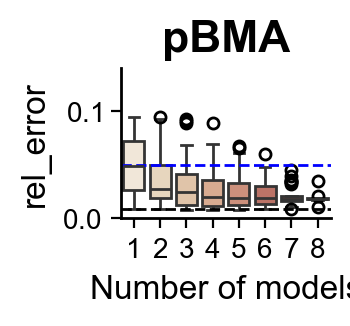

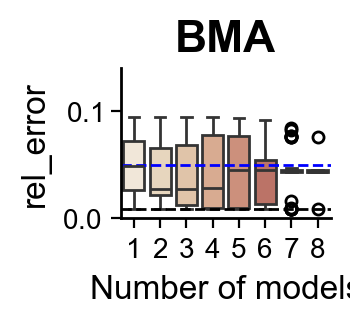

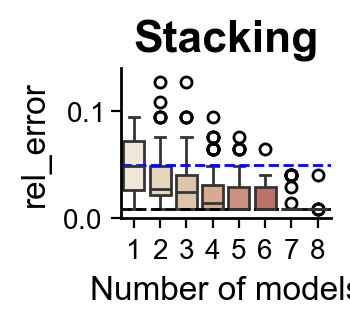

In [12]:
# pBMA rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.14])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_rel_error_pBMA.pdf', bbox_inches='tight', transparent=True)

# BMA rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.14])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_rel_error_BMA.pdf', bbox_inches='tight', transparent=True)

# stack rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.14])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_rel_error_stacking.pdf', bbox_inches='tight', transparent=True)

# save rel_error means
dat_df = pd.DataFrame({'pBMA': {key: np.mean(errors_pBMA[key]) for key in errors_pBMA.keys()},
                      'BMA': {key: np.mean(errors_BMA[key]) for key in errors_BMA.keys()},
                      'Stacking': {key: np.mean(errors_stack[key]) for key in errors_stack.keys()}})
dat_df.to_csv('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_rel_error_means.csv', index_label='number_of_models')

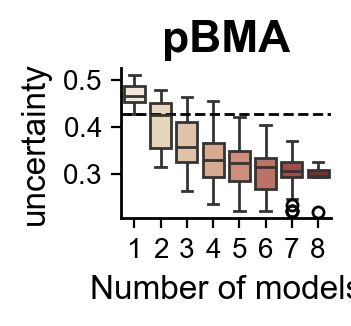

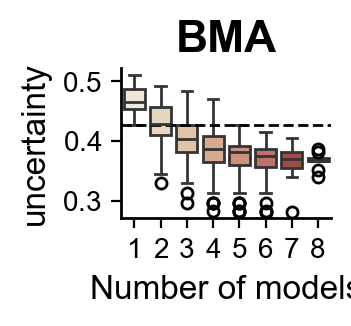

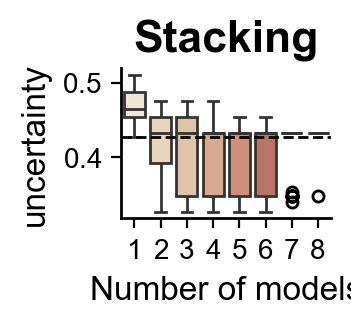

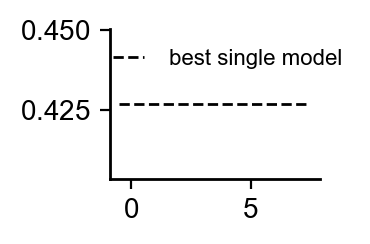

In [13]:
# pBMA uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_uncert95_pBMA.pdf', bbox_inches='tight', transparent=True)

# BMA uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_uncert95_BMA.pdf', bbox_inches='tight', transparent=True)

# stack uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_uncert95_stacking.pdf', bbox_inches='tight', transparent=True)

fig, ax = get_sized_fig_ax(1.05, 0.75)
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
leg = ax.legend(['best single model'], fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1.0))
export_legend(leg, filename='../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_uncert95_legend.pdf')

# save uncertainty means
dat_df = pd.DataFrame({'pBMA': {key: np.mean(uncertainties_pBMA[key]) for key in uncertainties_pBMA.keys()},
                      'BMA': {key: np.mean(uncertainties_BMA[key]) for key in uncertainties_BMA.keys()},
                      'Stacking': {key: np.mean(uncertainties_stack[key]) for key in uncertainties_stack.keys()}})
dat_df.to_csv('../../../results/MAPK/mmi/HF96_DR/mmi_combinatorics_uncert95_means.csv', index_label='number_of_models')